
图像分类是根据图像的语义信息将不同类别图像区分开来，是计算机视觉中重要的基本问题

猫狗分类属于图像分类中的粗粒度分类问题

![](https://ai-studio-static-online.cdn.bcebos.com/1cd9ef37036647c2afbbc866a7d2c14179f33cf1e2494d1f8f00de556d231452)


**首先导入必要的包**

paddle--->PaddlePaddle深度学习框架

os------------->python的模块，可使用该模块对操作系统进行操作

numpy---------->python第三方库，用于进行科学计算

PIL------------> Python Image Library,python第三方图像处理库

matplotlib----->python的绘图库 pyplot:matplotlib的绘图框架

os------------->提供了丰富的方法来处理文件和目录

sys------------->供对解释器使用或维护的一些变量的访问，以及与解释器强烈交互的函数。

pickle---------->模块实现了基本的数据序列和反序列化

In [31]:
# 
# 导入需要的包
import paddle
import numpy as np
from PIL import Image
import sys
import matplotlib.pyplot as plt
import os
import sys 
import pickle
print("本教程基于Paddle的版本号为："+paddle.__version__)


本教程基于Paddle的版本号为：2.2.2


In [32]:
import paddle
# 设置随机数种子
paddle.seed(2023)

NUM_EPOCHS = 100
BATCHSIZE = 10
LEARNINGRATE = 0.0011

print(LEARNINGRATE,BATCHSIZE,NUM_EPOCHS)

0.003 10 100


# **Step1:准备数据**
**（1）数据集介绍**

我们使用CIFAR10数据集。CIFAR10数据集包含60,000张32x32的彩色图片，10个类别，每个类包含6,000张。其中50,000张图片作为训练集，10000张作为验证集。这次我们只对其中的猫和狗两类进行预测。

![](https://ai-studio-static-online.cdn.bcebos.com/567016c028714d21bfe690dee70e9ea31512ba3575bd4d7caebbb7ade05c72ac)

**(2)train_reader和test_reader**

自定义读取器处理训练集和测试集

paddle.reader.shuffle()表示每次缓存BUF_SIZE个数据项，并进行打乱

paddle.batch()表示每BATCH_SIZE组成一个batch

In [33]:
#解压数据集
# !tar -zxvf cifar-10-python.tar.gz
# !cp cifar-10-python.tar.gz /home/aistudio/.cache/paddle/dataset/cifar/

In [34]:
'''
#定义数据序列化函数
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

print(unpickle("cifar-10-batches-py/data_batch_1").keys())
print(unpickle("cifar-10-batches-py/test_batch").keys())
'''

'\n#定义数据序列化函数\ndef unpickle(file):\n    with open(file, \'rb\') as fo:\n        dict = pickle.load(fo, encoding=\'bytes\')\n    return dict\n\nprint(unpickle("cifar-10-batches-py/data_batch_1").keys())\nprint(unpickle("cifar-10-batches-py/test_batch").keys())\n'

In [35]:
'''
自定义数据集
'''
import paddle.vision.transforms as T 

def get_train_transforms():
    return T.Compose([
        T.RandomCrop(32, padding=4),# 按0.5的概率随机裁剪图片
        T.RandomHorizontalFlip(0.5), # 按0.5的概率水平反转图片
        # T.Transpose(), # 格式转换
        T.ToTensor()
        # T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # 归一化
    ])

def get_test_transforms():
    return T.Compose([
        # T.Resize((32, 32)),
        # T.Transpose(),
        T.ToTensor()
        # T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),# 归一化处理
    ])

#paddle.seed(2023) #seed1

# 训练数据集
train_dataset = paddle.vision.datasets.Cifar10("data/data9154/cifar-10-python.tar.gz",mode='train', transform=get_train_transforms())

# 验证数据集
eval_dataset = paddle.vision.datasets.Cifar10("data/data9154/cifar-10-python.tar.gz",mode='test', transform=get_test_transforms())

# 测试定义的数据集
print('=============train_dataset =============')
#输出数据集的形状和标签
print(train_dataset.__getitem__(1)[0].shape,train_dataset.__getitem__(1)[1])
#输出数据集的长度
print(train_dataset.__len__())
print('=============eval_dataset =============')
#输出数据集的形状和标签
for data, label in eval_dataset:
    print(data.shape, label)
    break
#输出数据集的长度
print(eval_dataset.__len__())

=============train_dataset =============
[3, 32, 32] 9
50000
=============eval_dataset =============
[3, 32, 32] 3
10000


# **Step2.网络配置**

**（1）网络搭建**


In [36]:
#定义CNN网络
class MyCNN(paddle.nn.Layer):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv0 = paddle.nn.Conv2D(in_channels=3, out_channels=20, kernel_size=5, padding=0)
        self.pool0 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self._batch_norm_0 = paddle.nn.BatchNorm2D(num_features = 20)

        self.conv1 = paddle.nn.Conv2D(in_channels=20, out_channels=50, kernel_size=5, padding=0)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self._batch_norm_1 = paddle.nn.BatchNorm2D(num_features = 50)

        self.conv2 = paddle.nn.Conv2D(in_channels=50, out_channels=50, kernel_size=5, padding=0)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size =2, stride =2)
        self.fc1 = paddle.nn.Linear(in_features=50, out_features=10)
    
    def forward(self,input):
        #将输入数据的样子该变成[1,3,32,32]
        input = paddle.reshape(input,shape=[-1,3,32,32])
        x = self.conv0(input)
        x = paddle.nn.functional.relu(x)
        x = self.pool0(x)
        x = self._batch_norm_0(x)

        x = self.conv1(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool1(x)
        x = self._batch_norm_1(x)

        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool2(x)
        x = paddle.reshape(x, [x.shape[0], -1])
        x = self.fc1(x)
        y = paddle.nn.functional.softmax(x)
        return y

In [37]:
import paddle
from paddle import nn
from paddle.vision.models.resnet import BasicBlock


class ResNet(nn.Layer):
    def __init__(self, block, depth, num_classes=10):
        super(ResNet, self).__init__()
        #paddle.seed(2023) #seed2
        layer_cfg = {
            20: [3, 3, 3],
            32: [5, 5, 5],
            44: [7, 7, 7],
            56: [9, 9, 9],
            110:[18, 18, 18],
            1202:[200, 200, 200],
        }
        layers = layer_cfg[depth]
        self.num_classes = num_classes
        self._norm_layer = nn.BatchNorm2D

        self.inplanes = 16
        self.dilation = 1

        self.conv1 = nn.Conv2D(
            3,
            self.inplanes,
            kernel_size=3,
            stride=1,
            padding=1,
            bias_attr=False)
        self.bn1 = self._norm_layer(self.inplanes)
        self.relu = nn.ReLU()
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2D((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2D(
                    self.inplanes,
                    planes * block.expansion,
                    1,
                    stride=stride,
                    bias_attr=False),
                norm_layer(planes * block.expansion), )

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, downsample, 1, 16,
                  previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, norm_layer=norm_layer))

        return nn.Sequential(*layers)

    # @paddle.jit.to_static(input_spec=[paddle.static.InputSpec(shape=[None, 3, 32, 32], name='x')])
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = paddle.flatten(x, 1)
        x = self.fc(x)

        return x


# **Step3.模型训练 and Step4.模型评估**

In [38]:

#step3:训练模型
'''
# 用Model封装模型
model = paddle.Model(MyCNN())
# 定义损失函数
model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),paddle.nn.CrossEntropyLoss(),paddle.metric.Accuracy(topk=(1,5)))'''
#step3:训练模型
# 用Model封装模型
model = paddle.Model(ResNet(BasicBlock, 20))
# 定义损失函数

###model.prepare(paddle.optimizer.Adam(parameters=model.parameters()),paddle.nn.CrossEntropyLoss(),paddle.metric.Accuracy(topk=(1,5)))
model.prepare(paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=LEARNINGRATE),
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy(topk=(1,5)))


In [39]:
'''
# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')
# 启动模型全流程训练
model.fit(train_dataset,            # 训练数据集
           eval_dataset,            # 评估数据集
          epochs=5,            # 总的训练轮次
          batch_size = 256,    # 批次计算的样本量大小
          shuffle=True,             # 是否打乱样本集
          verbose=1,                # 日志展示格式
          save_dir='./chk_points/', # 分阶段的训练模型存储路径
          callbacks=[visualdl])     # 回调函数使用
#保存模型
model.save('model_save_dir')
'''

#paddle.seed(2023) #seed3

# 训练可视化VisualDL工具的回调函数
visualdl = paddle.callbacks.VisualDL(log_dir='visualdl_log')
# 启动模型全流程训练
model.fit(train_dataset,            # 训练数据集
           eval_dataset,            # 评估数据集
          epochs=NUM_EPOCHS,            # 总的训练轮次
          batch_size = BATCHSIZE,    # 批次计算的样本量大小
          shuffle=True,             # 是否打乱样本集
          verbose=1,                # 日志展示格式
          save_dir='./resnet_chk_points/', # 分阶段的训练模型存储路径
          callbacks=[visualdl])     # 回调函数使用
#保存模型
model.save('resnet_model_save_dir')

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/100
step   40/5000 [..............................] - loss: 2.4489 - acc_top1: 0.1475 - acc_top5: 0.6250 - ETA: 1:53 - 23ms/st

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


step 5000/5000 [==============================] - loss: 1.1609 - acc_top1: 0.4617 - acc_top5: 0.9062 - 22ms/step         
save checkpoint at /home/aistudio/resnet_chk_points/0
Eval begin...
step 1000/1000 [==============================] - loss: 1.1682 - acc_top1: 0.6407 - acc_top5: 0.9691 - 10ms/step         
Eval samples: 10000
Epoch 2/100
step 5000/5000 [==============================] - loss: 0.5905 - acc_top1: 0.6521 - acc_top5: 0.9651 - 21ms/step        
save checkpoint at /home/aistudio/resnet_chk_points/1
Eval begin...
step 1000/1000 [==============================] - loss: 0.7389 - acc_top1: 0.6993 - acc_top5: 0.9813 - 10ms/step        
Eval samples: 10000
Epoch 3/100
step 5000/5000 [==============================] - loss: 0.4938 - acc_top1: 0.7196 - acc_top5: 0.9783 - 21ms/step        
save checkpoint at /home/aistudio/resnet_chk_points/2
Eval begin...
step 1000/1000 [==============================] - loss: 0.3714 - acc_top1: 0.7599 - acc_top5: 0.9849 - 10ms/step        
Eval

In [40]:
result = model.evaluate(eval_dataset, batch_size=100)
print(result)

Eval begin...
step  10/100 - loss: 0.3260 - acc_top1: 0.9030 - acc_top5: 0.9980 - 43ms/step
step  20/100 - loss: 0.6620 - acc_top1: 0.8990 - acc_top5: 0.9975 - 42ms/step
step  30/100 - loss: 0.3184 - acc_top1: 0.8963 - acc_top5: 0.9973 - 42ms/step
step  40/100 - loss: 0.3070 - acc_top1: 0.8968 - acc_top5: 0.9960 - 42ms/step
step  50/100 - loss: 0.6097 - acc_top1: 0.8926 - acc_top5: 0.9964 - 42ms/step
step  60/100 - loss: 0.5131 - acc_top1: 0.8920 - acc_top5: 0.9967 - 42ms/step
step  70/100 - loss: 0.4036 - acc_top1: 0.8947 - acc_top5: 0.9971 - 42ms/step
step  80/100 - loss: 0.4715 - acc_top1: 0.8938 - acc_top5: 0.9971 - 42ms/step
step  90/100 - loss: 0.4681 - acc_top1: 0.8944 - acc_top5: 0.9971 - 42ms/step
step 100/100 - loss: 0.3979 - acc_top1: 0.8948 - acc_top5: 0.9973 - 42ms/step
Eval samples: 10000
{'loss': [0.3978956], 'acc_top1': 0.8948, 'acc_top5': 0.9973}


In [41]:
def load_image(file):
        #打开图片
        im = Image.open(file)
        #将图片调整为跟训练数据一样的大小  32*32，设定ANTIALIAS，即抗锯齿.resize是缩放
        im = im.resize((32, 32), Image.ANTIALIAS)
        #建立图片矩阵 类型为float32
        im = np.array(im).astype(np.float32)
        #矩阵转置 
        im = im.transpose((2, 0, 1))                               
        #将像素值从【0-255】转换为【0-1】
        im = im / 255.0
        #print(im)       
        im = np.expand_dims(im, axis=0)
        # 保持和之前输入image维度一致
        print('im_shape的维度：',im.shape)
        return im


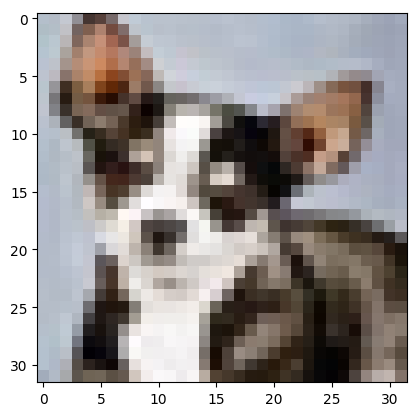

im_shape的维度： (1, 3, 32, 32)
Predict begin...
step 1/1 [==============================] - 8ms/step
Predict samples: 1
results [(array([[-28.125544  , -32.684277  , -19.274145  ,  -5.595836  ,
        -14.94391   ,   0.85663545, -40.264088  , -18.188118  ,
        -35.83583   , -32.501835  ]], dtype=float32),)]
infer results: dog


In [42]:
from paddle.static import InputSpec

#定义标签列表
label_list = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse","ship", "truck"]
#读入测试图片并展示
infer_path='/home/aistudio/data/data7940/dog.png'
img = Image.open(infer_path)
plt.imshow(img)   
plt.show()    


#载入要预测的图片
infer_img = load_image(infer_path)
# #将图片变为数组
infer_img=np.array(infer_img).astype('float32')
infer_img = np.expand_dims(infer_img, axis=0)
# print(infer_img.shape)
#进行预测
result = model.predict(infer_img)
#输出预测结果
print('results',result)
print("infer results: %s" % label_list[np.argmax(result[0][0])])  

In [43]:
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import seaborn as sns
import paddle

model__state_dict = paddle.load('resnet_chk_points/final.pdparams')
model_eval = ResNet(BasicBlock, 20)
model_eval.set_state_dict(model__state_dict) 
model_eval.eval()

eval_loader = paddle.io.DataLoader(eval_dataset, batch_size = 8, shuffle=False)
y_p = [] #预测值
y_t = [] #真实值
for batch, (test_X,test_y) in enumerate(eval_loader()):
    y_pred = model_eval(test_X)
    for i in y_pred:
        y_p.append(np.argmax(i))
        # print(i)
    for i in test_y:
        y_t.append(int(i))

In [44]:
print('f1_score:',f1_score(y_t,y_p,average='micro'))
print(classification_report(y_t,y_p,digits=7))

f1_score: 0.8948
              precision    recall  f1-score   support

           0  0.9130879 0.8930000 0.9029323      1000
           1  0.9388560 0.9520000 0.9453823      1000
           2  0.8717172 0.8630000 0.8673367      1000
           3  0.8520179 0.7600000 0.8033827      1000
           4  0.8384477 0.9290000 0.8814042      1000
           5  0.8317025 0.8500000 0.8407517      1000
           6  0.9101678 0.9220000 0.9160457      1000
           7  0.9243952 0.9170000 0.9206827      1000
           8  0.9351944 0.9380000 0.9365951      1000
           9  0.9352227 0.9240000 0.9295775      1000

    accuracy                      0.8948000     10000
   macro avg  0.8950809 0.8948000 0.8944091     10000
weighted avg  0.8950809 0.8948000 0.8944091     10000



/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)
/opt/conda/envs/python35-pad

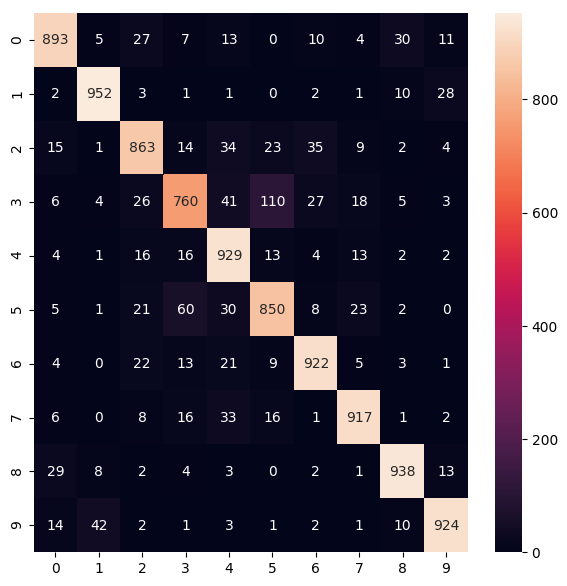

In [45]:
plt.figure(figsize=(7,7))
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False

plt.xlabel('pre')
plt.ylabel('real')
sns.heatmap(confusion_matrix(y_t,y_p),annot=True,fmt="d")